In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 1,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_1_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:31 - loss: 0.3155 - STD: 8.3332e-05 - MAE: 0.5535

 4/74 [>.............................] - ETA: 2s - loss: 0.1143 - STD: 4.8850e-04 - MAE: 0.2683  

 5/74 [=>............................] - ETA: 2s - loss: 0.0944 - STD: 4.3722e-04 - MAE: 0.2324

 6/74 [=>............................] - ETA: 2s - loss: 0.0822 - STD: 3.8537e-04 - MAE: 0.2126

 7/74 [=>............................] - ETA: 3s - loss: 0.0740 - STD: 3.4080e-04 - MAE: 0.2004

 8/74 [==>...........................] - ETA: 8s - loss: 0.0714 - STD: 3.0380e-04 - MAE: 0.1924

12/74 [===>..........................] - ETA: 5s - loss: 0.0573 - STD: 2.0821e-04 - MAE: 0.1777

13/74 [====>.........................] - ETA: 5s - loss: 0.0553 - STD: 1.9257e-04 - MAE: 0.1758

14/74 [====>.........................] - ETA: 4s - loss: 0.0536 - STD: 1.7903e-04 - MAE: 0.1741

15/74 [=====>........................] - ETA: 4s - loss: 0.0521 - STD: 1.6725e-04 - MAE: 0.1726

16/74 [=====>........................] - ETA: 4s - loss: 0.0507 - STD: 1.5698e-04 - MAE: 0.1711

17/74 [=====>........................] - ETA: 4s - loss: 0.0496 - STD: 1.4797e-04 - MAE: 0.1698

18/74 [======>.......................] - ETA: 4s - loss: 0.0484 - STD: 1.3997e-04 - MAE: 0.1684

19/74 [======>.......................] - ETA: 4s - loss: 0.0474 - STD: 1.3287e-04 - MAE: 0.1671

20/74 [=======>......................] - ETA: 4s - loss: 0.0464 - STD: 1.2646e-04 - MAE: 0.1656

21/74 [=======>......................] - ETA: 4s - loss: 0.0455 - STD: 1.2067e-04 - MAE: 0.1641

22/74 [=======>......................] - ETA: 3s - loss: 0.0445 - STD: 1.1550e-04 - MAE: 0.1625

23/74 [========>.....................] - ETA: 3s - loss: 0.0436 - STD: 1.1078e-04 - MAE: 0.1609

24/74 [========>.....................] - ETA: 3s - loss: 0.0427 - STD: 1.0645e-04 - MAE: 0.1591

25/74 [=========>....................] - ETA: 3s - loss: 0.0418 - STD: 1.0250e-04 - MAE: 0.1572

26/74 [=========>....................] - ETA: 3s - loss: 0.0409 - STD: 9.8897e-05 - MAE: 0.1551

27/74 [=========>....................] - ETA: 3s - loss: 0.0399 - STD: 9.5581e-05 - MAE: 0.1528

28/74 [==========>...................] - ETA: 3s - loss: 0.0390 - STD: 9.2516e-05 - MAE: 0.1505

29/74 [==========>...................] - ETA: 3s - loss: 0.0381 - STD: 8.9690e-05 - MAE: 0.1481

30/74 [===========>..................] - ETA: 3s - loss: 0.0371 - STD: 8.7115e-05 - MAE: 0.1457

31/74 [===========>..................] - ETA: 3s - loss: 0.0362 - STD: 8.4740e-05 - MAE: 0.1433

32/74 [===========>..................] - ETA: 3s - loss: 0.0354 - STD: 8.2520e-05 - MAE: 0.1412

33/74 [============>.................] - ETA: 3s - loss: 0.0346 - STD: 8.0463e-05 - MAE: 0.1392

34/74 [============>.................] - ETA: 2s - loss: 0.0338 - STD: 7.8531e-05 - MAE: 0.1375

35/74 [=============>................] - ETA: 2s - loss: 0.0332 - STD: 7.6717e-05 - MAE: 0.1361

36/74 [=============>................] - ETA: 2s - loss: 0.0326 - STD: 7.5090e-05 - MAE: 0.1348

37/74 [==============>...............] - ETA: 2s - loss: 0.0320 - STD: 7.3530e-05 - MAE: 0.1337

38/74 [==============>...............] - ETA: 2s - loss: 0.0315 - STD: 7.1951e-05 - MAE: 0.1327

39/74 [==============>...............] - ETA: 2s - loss: 0.0310 - STD: 7.0454e-05 - MAE: 0.1317

40/74 [===============>..............] - ETA: 2s - loss: 0.0305 - STD: 6.9016e-05 - MAE: 0.1307

41/74 [===============>..............] - ETA: 2s - loss: 0.0300 - STD: 6.7614e-05 - MAE: 0.1296

42/74 [================>.............] - ETA: 2s - loss: 0.0295 - STD: 6.6206e-05 - MAE: 0.1285

43/74 [================>.............] - ETA: 2s - loss: 0.0290 - STD: 6.4853e-05 - MAE: 0.1274

44/74 [================>.............] - ETA: 2s - loss: 0.0286 - STD: 6.3532e-05 - MAE: 0.1263

45/74 [=================>............] - ETA: 2s - loss: 0.0282 - STD: 6.2304e-05 - MAE: 0.1252

46/74 [=================>............] - ETA: 1s - loss: 0.0277 - STD: 6.1064e-05 - MAE: 0.1241

47/74 [==================>...........] - ETA: 1s - loss: 0.0273 - STD: 5.9886e-05 - MAE: 0.1230

48/74 [==================>...........] - ETA: 1s - loss: 0.0270 - STD: 5.8733e-05 - MAE: 0.1220

49/74 [==================>...........] - ETA: 1s - loss: 0.0266 - STD: 5.7636e-05 - MAE: 0.1210

50/74 [===================>..........] - ETA: 1s - loss: 0.0263 - STD: 5.6587e-05 - MAE: 0.1201

51/74 [===================>..........] - ETA: 1s - loss: 0.0260 - STD: 5.5560e-05 - MAE: 0.1192

52/74 [====================>.........] - ETA: 1s - loss: 0.0257 - STD: 5.4565e-05 - MAE: 0.1183

53/74 [====================>.........] - ETA: 1s - loss: 0.0254 - STD: 5.3604e-05 - MAE: 0.1175

54/74 [====================>.........] - ETA: 1s - loss: 0.0251 - STD: 5.2685e-05 - MAE: 0.1167

55/74 [=====================>........] - ETA: 1s - loss: 0.0248 - STD: 5.1795e-05 - MAE: 0.1159

56/74 [=====================>........] - ETA: 1s - loss: 0.0245 - STD: 5.0949e-05 - MAE: 0.1152

57/74 [======================>.......] - ETA: 1s - loss: 0.0242 - STD: 5.0142e-05 - MAE: 0.1145

58/74 [======================>.......] - ETA: 1s - loss: 0.0240 - STD: 4.9359e-05 - MAE: 0.1138

59/74 [======================>.......] - ETA: 1s - loss: 0.0237 - STD: 4.8617e-05 - MAE: 0.1131

60/74 [=======================>......] - ETA: 0s - loss: 0.0235 - STD: 4.7863e-05 - MAE: 0.1125

61/74 [=======================>......] - ETA: 0s - loss: 0.0232 - STD: 4.7149e-05 - MAE: 0.1119

62/74 [========================>.....] - ETA: 0s - loss: 0.0230 - STD: 4.6484e-05 - MAE: 0.1113

63/74 [========================>.....] - ETA: 0s - loss: 0.0228 - STD: 4.5846e-05 - MAE: 0.1107

64/74 [========================>.....] - ETA: 0s - loss: 0.0226 - STD: 4.5207e-05 - MAE: 0.1102

65/74 [=========================>....] - ETA: 0s - loss: 0.0224 - STD: 4.4589e-05 - MAE: 0.1097

66/74 [=========================>....] - ETA: 0s - loss: 0.0222 - STD: 4.3995e-05 - MAE: 0.1093

67/74 [==========================>...] - ETA: 0s - loss: 0.0220 - STD: 4.3414e-05 - MAE: 0.1088

68/74 [==========================>...] - ETA: 0s - loss: 0.0218 - STD: 4.2863e-05 - MAE: 0.1083

69/74 [==========================>...] - ETA: 0s - loss: 0.0216 - STD: 4.2316e-05 - MAE: 0.1079

70/74 [===========================>..] - ETA: 0s - loss: 0.0214 - STD: 4.1813e-05 - MAE: 0.1074

71/74 [===========================>..] - ETA: 0s - loss: 0.0213 - STD: 4.1299e-05 - MAE: 0.1070

72/74 [============================>.] - ETA: 0s - loss: 0.0211 - STD: 4.0786e-05 - MAE: 0.1066

73/74 [============================>.] - ETA: 0s - loss: 0.0209 - STD: 4.0307e-05 - MAE: 0.1061

74/74 [==============================] - ETA: 0s - loss: 0.0208 - STD: 3.9830e-05 - MAE: 0.1057

74/74 [==============================] - 7s 79ms/step - loss: 0.0208 - STD: 3.9830e-05 - MAE: 0.1057 - val_loss: 0.0086 - val_STD: 3.7578e-06 - val_MAE: 0.0711


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0092 - STD: 4.3453e-06 - MAE: 0.0746

 2/74 [..............................] - ETA: 5s - loss: 0.0093 - STD: 4.9782e-06 - MAE: 0.0750

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 4.8074e-06 - MAE: 0.0746

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 5.0888e-06 - MAE: 0.0749

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 5.2050e-06 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 5.1743e-06 - MAE: 0.0749

 7/74 [=>............................] - ETA: 4s - loss: 0.0094 - STD: 5.0241e-06 - MAE: 0.0752

 8/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 5.1041e-06 - MAE: 0.0751

 9/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 5.1217e-06 - MAE: 0.0751

10/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.1408e-06 - MAE: 0.0752

11/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.3092e-06 - MAE: 0.0752

12/74 [===>..........................] - ETA: 4s - loss: 0.0093 - STD: 5.3663e-06 - MAE: 0.0753

13/74 [====>.........................] - ETA: 4s - loss: 0.0093 - STD: 5.3483e-06 - MAE: 0.0753

14/74 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 5.3493e-06 - MAE: 0.0753

15/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.3940e-06 - MAE: 0.0753

16/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.4151e-06 - MAE: 0.0754

17/74 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 5.4599e-06 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 5.4967e-06 - MAE: 0.0753

19/74 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 5.4833e-06 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 5.5204e-06 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 5.5952e-06 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 5.6248e-06 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 5.6011e-06 - MAE: 0.0754

24/74 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 5.5996e-06 - MAE: 0.0754

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.5592e-06 - MAE: 0.0754

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.5096e-06 - MAE: 0.0753

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.4735e-06 - MAE: 0.0753

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 5.4382e-06 - MAE: 0.0753

29/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 5.4066e-06 - MAE: 0.0752

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.3759e-06 - MAE: 0.0752

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.3514e-06 - MAE: 0.0752

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.3302e-06 - MAE: 0.0752

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.3222e-06 - MAE: 0.0751

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.2840e-06 - MAE: 0.0751

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 5.3002e-06 - MAE: 0.0751

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 5.3133e-06 - MAE: 0.0751

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.3399e-06 - MAE: 0.0752

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.3559e-06 - MAE: 0.0751

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.3839e-06 - MAE: 0.0752

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.3911e-06 - MAE: 0.0752

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.4030e-06 - MAE: 0.0752

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 5.4272e-06 - MAE: 0.0752

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 5.4528e-06 - MAE: 0.0752

44/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 5.4720e-06 - MAE: 0.0752

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.4981e-06 - MAE: 0.0752

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 5.5180e-06 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.5383e-06 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.5554e-06 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.5733e-06 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.5936e-06 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.6091e-06 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.6195e-06 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.6406e-06 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.6669e-06 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.6799e-06 - MAE: 0.0753

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.6943e-06 - MAE: 0.0753

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 5.7117e-06 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 5.7524e-06 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.7763e-06 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.8036e-06 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.8349e-06 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.8676e-06 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.9023e-06 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.9388e-06 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.9590e-06 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9745e-06 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9812e-06 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9964e-06 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.0154e-06 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.0336e-06 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.0494e-06 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.0697e-06 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 6.0904e-06 - MAE: 0.0754

74/74 [==============================] - 5s 70ms/step - loss: 0.0092 - STD: 6.0904e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 5.2477e-06 - val_MAE: 0.0716


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0094 - STD: 7.2702e-06 - MAE: 0.0760

 2/74 [..............................] - ETA: 5s - loss: 0.0093 - STD: 7.3829e-06 - MAE: 0.0758

 3/74 [>.............................] - ETA: 5s - loss: 0.0093 - STD: 7.5862e-06 - MAE: 0.0756

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 7.7058e-06 - MAE: 0.0753

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 7.9028e-06 - MAE: 0.0754

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 8.1856e-06 - MAE: 0.0756

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 8.4197e-06 - MAE: 0.0755

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 8.5946e-06 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 8.7211e-06 - MAE: 0.0755

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 8.8598e-06 - MAE: 0.0754

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 8.9837e-06 - MAE: 0.0753

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 9.1295e-06 - MAE: 0.0754

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 9.2467e-06 - MAE: 0.0754

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 9.3238e-06 - MAE: 0.0754

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.4064e-06 - MAE: 0.0754

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.4926e-06 - MAE: 0.0754

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 9.5763e-06 - MAE: 0.0753

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 9.6682e-06 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 9.7559e-06 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 9.9335e-06 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.0106e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.0258e-05 - MAE: 0.0754

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.0398e-05 - MAE: 0.0755

24/74 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 1.0514e-05 - MAE: 0.0755

25/74 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 1.0614e-05 - MAE: 0.0755

26/74 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 1.0699e-05 - MAE: 0.0755

27/74 [=========>....................] - ETA: 3s - loss: 0.0093 - STD: 1.0794e-05 - MAE: 0.0755

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.0908e-05 - MAE: 0.0755

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.0968e-05 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1038e-05 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1127e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1249e-05 - MAE: 0.0754

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.1347e-05 - MAE: 0.0754

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.1459e-05 - MAE: 0.0754

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.1577e-05 - MAE: 0.0754

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.1692e-05 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.1794e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.1913e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2013e-05 - MAE: 0.0754

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.2092e-05 - MAE: 0.0753

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.2154e-05 - MAE: 0.0753

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 1.2235e-05 - MAE: 0.0753

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 1.2308e-05 - MAE: 0.0753

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.2379e-05 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.2463e-05 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.2552e-05 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.2644e-05 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.2732e-05 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.2817e-05 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.2902e-05 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.2992e-05 - MAE: 0.0753

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3085e-05 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3178e-05 - MAE: 0.0753

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3278e-05 - MAE: 0.0753

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.3384e-05 - MAE: 0.0753

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.3501e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.3633e-05 - MAE: 0.0753

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.3774e-05 - MAE: 0.0753

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.3941e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.4116e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.4288e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4466e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4658e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4858e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.5054e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.5237e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.5407e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.5581e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.5737e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.5898e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.6090e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.6284e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.6679e-05 - MAE: 0.0754

74/74 [==============================] - 5s 70ms/step - loss: 0.0092 - STD: 1.6679e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.9769e-05 - val_MAE: 0.0716


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0094 - STD: 3.0014e-05 - MAE: 0.0762

 2/74 [..............................] - ETA: 5s - loss: 0.0092 - STD: 3.0322e-05 - MAE: 0.0757

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 3.0796e-05 - MAE: 0.0754

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 3.1068e-05 - MAE: 0.0755

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 3.1078e-05 - MAE: 0.0755

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 3.1158e-05 - MAE: 0.0756

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 3.1246e-05 - MAE: 0.0756

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.1382e-05 - MAE: 0.0756

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.1490e-05 - MAE: 0.0755

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.1681e-05 - MAE: 0.0755

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.1909e-05 - MAE: 0.0756

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.2165e-05 - MAE: 0.0755

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 3.2466e-05 - MAE: 0.0754

14/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 3.2749e-05 - MAE: 0.0754

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.2991e-05 - MAE: 0.0755

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.3219e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.3468e-05 - MAE: 0.0755

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.3727e-05 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.4054e-05 - MAE: 0.0755

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.4421e-05 - MAE: 0.0755

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.4793e-05 - MAE: 0.0755

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.5165e-05 - MAE: 0.0755

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 3.5528e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 3.5870e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.6219e-05 - MAE: 0.0755

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.6546e-05 - MAE: 0.0755

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 3.6866e-05 - MAE: 0.0755

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 3.7224e-05 - MAE: 0.0755

29/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 3.7594e-05 - MAE: 0.0756

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.7973e-05 - MAE: 0.0756

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.8705e-05 - MAE: 0.0756

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.9092e-05 - MAE: 0.0756

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.9480e-05 - MAE: 0.0756

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.9838e-05 - MAE: 0.0756

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.0184e-05 - MAE: 0.0756

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.0508e-05 - MAE: 0.0756

38/74 [==============>...............] - ETA: 2s - loss: 0.0093 - STD: 4.0838e-05 - MAE: 0.0756

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.1204e-05 - MAE: 0.0756

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 4.1575e-05 - MAE: 0.0756

41/74 [===============>..............] - ETA: 2s - loss: 0.0093 - STD: 4.1971e-05 - MAE: 0.0756

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 4.2380e-05 - MAE: 0.0756

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 4.2808e-05 - MAE: 0.0756

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.3237e-05 - MAE: 0.0755

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.3717e-05 - MAE: 0.0755

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.4220e-05 - MAE: 0.0755

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 4.4745e-05 - MAE: 0.0755

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 4.5275e-05 - MAE: 0.0755

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 4.5791e-05 - MAE: 0.0755

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 4.6302e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 4.6836e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.7355e-05 - MAE: 0.0755

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.7888e-05 - MAE: 0.0755

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 4.8427e-05 - MAE: 0.0755

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 4.8973e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 4.9543e-05 - MAE: 0.0755

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 5.0098e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 5.0671e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 5.1279e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.1895e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.2513e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.3158e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.3802e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.4473e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.5122e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.5784e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.6472e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.7155e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.7862e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 5.8577e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 5.9320e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.0079e-05 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.0858e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 6.1652e-05 - MAE: 0.0754

74/74 [==============================] - 5s 71ms/step - loss: 0.0092 - STD: 6.1652e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 8.0045e-05 - val_MAE: 0.0717


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0093 - STD: 1.2239e-04 - MAE: 0.0757

 2/74 [..............................] - ETA: 5s - loss: 0.0091 - STD: 1.2400e-04 - MAE: 0.0752

 3/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 1.2492e-04 - MAE: 0.0751

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 1.2642e-04 - MAE: 0.0752

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 1.2918e-04 - MAE: 0.0751

 7/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 1.3086e-04 - MAE: 0.0751

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.3233e-04 - MAE: 0.0751

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.3402e-04 - MAE: 0.0751

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.3561e-04 - MAE: 0.0751

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.3735e-04 - MAE: 0.0750

12/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 1.3914e-04 - MAE: 0.0749

13/74 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 1.4104e-04 - MAE: 0.0750

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.4327e-04 - MAE: 0.0750

15/74 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 1.4542e-04 - MAE: 0.0751

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.4740e-04 - MAE: 0.0751

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.4960e-04 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.5184e-04 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.5419e-04 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.5658e-04 - MAE: 0.0752

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.5896e-04 - MAE: 0.0753

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.6136e-04 - MAE: 0.0753

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.6394e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.6656e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.6912e-04 - MAE: 0.0753

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.7190e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.7462e-04 - MAE: 0.0753

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.7747e-04 - MAE: 0.0753

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.8042e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8342e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8649e-04 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.8958e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.9269e-04 - MAE: 0.0753

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.9594e-04 - MAE: 0.0753

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.9935e-04 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 2.0282e-04 - MAE: 0.0754

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.0637e-04 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.1006e-04 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.1378e-04 - MAE: 0.0754

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.1765e-04 - MAE: 0.0754

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.2162e-04 - MAE: 0.0754

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 2.2563e-04 - MAE: 0.0753

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 2.2968e-04 - MAE: 0.0753

44/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 2.3400e-04 - MAE: 0.0753

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.3846e-04 - MAE: 0.0753

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.4303e-04 - MAE: 0.0753

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.4769e-04 - MAE: 0.0753

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.5250e-04 - MAE: 0.0753

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.5749e-04 - MAE: 0.0753

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.6261e-04 - MAE: 0.0753

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.6788e-04 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.7327e-04 - MAE: 0.0753

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.7907e-04 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.8485e-04 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.9077e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 2.9687e-04 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.0320e-04 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.0972e-04 - MAE: 0.0754

59/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.1637e-04 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.2322e-04 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.3032e-04 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.3769e-04 - MAE: 0.0753

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.4520e-04 - MAE: 0.0753

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.5307e-04 - MAE: 0.0753

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.6112e-04 - MAE: 0.0753

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.6939e-04 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.7798e-04 - MAE: 0.0753

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.8683e-04 - MAE: 0.0753

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.9597e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.0543e-04 - MAE: 0.0753

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 4.1533e-04 - MAE: 0.0753

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.2534e-04 - MAE: 0.0753

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 4.3595e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.4681e-04 - MAE: 0.0753

74/74 [==============================] - 5s 70ms/step - loss: 0.0092 - STD: 4.4681e-04 - MAE: 0.0753 - val_loss: 0.0085 - val_STD: 8.4212e-04 - val_MAE: 0.0712


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0092 - STD: 0.0013 - MAE: 0.0754

 2/74 [..............................] - ETA: 4s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0749

 3/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0748

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0748

 5/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0748

 7/74 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.0015 - MAE: 0.0747

 8/74 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0015 - MAE: 0.0747

 9/74 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0015 - MAE: 0.0748

10/74 [===>..........................] - ETA: 4s - loss: 0.0090 - STD: 0.0015 - MAE: 0.0747

12/74 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0016 - MAE: 0.0746

13/74 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0017 - MAE: 0.0746

14/74 [====>.........................] - ETA: 3s - loss: 0.0090 - STD: 0.0017 - MAE: 0.0747

15/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0017 - MAE: 0.0746

16/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0746

17/74 [=====>........................] - ETA: 3s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0747

18/74 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0018 - MAE: 0.0747

19/74 [======>.......................] - ETA: 3s - loss: 0.0090 - STD: 0.0019 - MAE: 0.0747

20/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0019 - MAE: 0.0747

21/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

22/74 [=======>......................] - ETA: 3s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

23/74 [========>.....................] - ETA: 3s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0747

24/74 [========>.....................] - ETA: 3s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0746

25/74 [=========>....................] - ETA: 3s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0746

26/74 [=========>....................] - ETA: 3s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0746

27/74 [=========>....................] - ETA: 3s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0745

28/74 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0745

29/74 [==========>...................] - ETA: 2s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0745

30/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0745

31/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0745

32/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0745

33/74 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0745

34/74 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0745

35/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0745

36/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0745

37/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0745

38/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0744

39/74 [==============>...............] - ETA: 2s - loss: 0.0089 - STD: 0.0031 - MAE: 0.0744

40/74 [===============>..............] - ETA: 2s - loss: 0.0089 - STD: 0.0032 - MAE: 0.0744

41/74 [===============>..............] - ETA: 2s - loss: 0.0089 - STD: 0.0032 - MAE: 0.0744

42/74 [================>.............] - ETA: 2s - loss: 0.0089 - STD: 0.0033 - MAE: 0.0743

43/74 [================>.............] - ETA: 2s - loss: 0.0089 - STD: 0.0034 - MAE: 0.0743

44/74 [================>.............] - ETA: 1s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0743

45/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0743

46/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0742

47/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0742

48/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0742

49/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0742

50/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0741

51/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0741

52/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0043 - MAE: 0.0741

53/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0045 - MAE: 0.0741

54/74 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.0046 - MAE: 0.0740

55/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0047 - MAE: 0.0740

56/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0739

57/74 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0050 - MAE: 0.0739

58/74 [======================>.......] - ETA: 1s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0739

59/74 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0738

60/74 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0738

61/74 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0738

62/74 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0057 - MAE: 0.0737

63/74 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0737

64/74 [========================>.....] - ETA: 0s - loss: 0.0088 - STD: 0.0060 - MAE: 0.0736

65/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0736

66/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0735

67/74 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0735

68/74 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0734

69/74 [==========================>...] - ETA: 0s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0734

70/74 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0733

71/74 [===========================>..] - ETA: 0s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0732

72/74 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0732

73/74 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0076 - MAE: 0.0731

74/74 [==============================] - ETA: 0s - loss: 0.0086 - STD: 0.0078 - MAE: 0.0731

74/74 [==============================] - 5s 70ms/step - loss: 0.0086 - STD: 0.0078 - MAE: 0.0731 - val_loss: 0.0069 - val_STD: 0.0144 - val_MAE: 0.0640


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0074 - STD: 0.0229 - MAE: 0.0680

 2/74 [..............................] - ETA: 5s - loss: 0.0076 - STD: 0.0232 - MAE: 0.0683

 3/74 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.0235 - MAE: 0.0685

 4/74 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.0239 - MAE: 0.0687

 5/74 [=>............................] - ETA: 4s - loss: 0.0076 - STD: 0.0243 - MAE: 0.0687

 6/74 [=>............................] - ETA: 4s - loss: 0.0076 - STD: 0.0246 - MAE: 0.0685

 7/74 [=>............................] - ETA: 4s - loss: 0.0075 - STD: 0.0249 - MAE: 0.0683

 8/74 [==>...........................] - ETA: 4s - loss: 0.0075 - STD: 0.0253 - MAE: 0.0682

 9/74 [==>...........................] - ETA: 4s - loss: 0.0075 - STD: 0.0256 - MAE: 0.0680

10/74 [===>..........................] - ETA: 4s - loss: 0.0074 - STD: 0.0260 - MAE: 0.0678

11/74 [===>..........................] - ETA: 4s - loss: 0.0074 - STD: 0.0263 - MAE: 0.0677

12/74 [===>..........................] - ETA: 4s - loss: 0.0074 - STD: 0.0267 - MAE: 0.0677

13/74 [====>.........................] - ETA: 4s - loss: 0.0074 - STD: 0.0270 - MAE: 0.0675

14/74 [====>.........................] - ETA: 3s - loss: 0.0073 - STD: 0.0273 - MAE: 0.0673

15/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0276 - MAE: 0.0672

16/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0280 - MAE: 0.0670

17/74 [=====>........................] - ETA: 3s - loss: 0.0073 - STD: 0.0283 - MAE: 0.0669

18/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0286 - MAE: 0.0668

19/74 [======>.......................] - ETA: 3s - loss: 0.0072 - STD: 0.0290 - MAE: 0.0667

20/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0293 - MAE: 0.0667

21/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0297 - MAE: 0.0665

22/74 [=======>......................] - ETA: 3s - loss: 0.0072 - STD: 0.0300 - MAE: 0.0664

23/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0303 - MAE: 0.0662

24/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0307 - MAE: 0.0661

25/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0310 - MAE: 0.0660

26/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0314 - MAE: 0.0659

27/74 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0317 - MAE: 0.0658

28/74 [==========>...................] - ETA: 3s - loss: 0.0070 - STD: 0.0321 - MAE: 0.0657

29/74 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0324 - MAE: 0.0656

30/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0327 - MAE: 0.0655

31/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0331 - MAE: 0.0653

32/74 [===========>..................] - ETA: 2s - loss: 0.0069 - STD: 0.0334 - MAE: 0.0652

33/74 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0338 - MAE: 0.0651

34/74 [============>.................] - ETA: 2s - loss: 0.0069 - STD: 0.0341 - MAE: 0.0650

35/74 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0344 - MAE: 0.0649

36/74 [=============>................] - ETA: 2s - loss: 0.0069 - STD: 0.0348 - MAE: 0.0648

37/74 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.0351 - MAE: 0.0647

38/74 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0354 - MAE: 0.0646

39/74 [==============>...............] - ETA: 2s - loss: 0.0068 - STD: 0.0357 - MAE: 0.0645

40/74 [===============>..............] - ETA: 2s - loss: 0.0068 - STD: 0.0360 - MAE: 0.0644

41/74 [===============>..............] - ETA: 2s - loss: 0.0068 - STD: 0.0363 - MAE: 0.0643

42/74 [================>.............] - ETA: 2s - loss: 0.0068 - STD: 0.0366 - MAE: 0.0642

43/74 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.0369 - MAE: 0.0641

44/74 [================>.............] - ETA: 2s - loss: 0.0067 - STD: 0.0371 - MAE: 0.0640

45/74 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0374 - MAE: 0.0639

46/74 [=================>............] - ETA: 1s - loss: 0.0067 - STD: 0.0376 - MAE: 0.0638

47/74 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0379 - MAE: 0.0638

48/74 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0381 - MAE: 0.0637

49/74 [==================>...........] - ETA: 1s - loss: 0.0067 - STD: 0.0383 - MAE: 0.0636

50/74 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0386 - MAE: 0.0635

51/74 [===================>..........] - ETA: 1s - loss: 0.0066 - STD: 0.0388 - MAE: 0.0634

52/74 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0390 - MAE: 0.0633

53/74 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0392 - MAE: 0.0633

54/74 [====================>.........] - ETA: 1s - loss: 0.0066 - STD: 0.0395 - MAE: 0.0632

55/74 [=====================>........] - ETA: 1s - loss: 0.0066 - STD: 0.0397 - MAE: 0.0631

56/74 [=====================>........] - ETA: 1s - loss: 0.0065 - STD: 0.0399 - MAE: 0.0630

57/74 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0401 - MAE: 0.0629

58/74 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0403 - MAE: 0.0628

59/74 [======================>.......] - ETA: 1s - loss: 0.0065 - STD: 0.0406 - MAE: 0.0627

60/74 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0407 - MAE: 0.0627

61/74 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0409 - MAE: 0.0626

62/74 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0412 - MAE: 0.0625

63/74 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0413 - MAE: 0.0624

65/74 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0417 - MAE: 0.0623

66/74 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0419 - MAE: 0.0622

67/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0421 - MAE: 0.0621

68/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0423 - MAE: 0.0621

69/74 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0425 - MAE: 0.0620

70/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0426 - MAE: 0.0619

71/74 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0428 - MAE: 0.0619

72/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0430 - MAE: 0.0618

73/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0432 - MAE: 0.0617

74/74 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0434 - MAE: 0.0617

74/74 [==============================] - 5s 70ms/step - loss: 0.0063 - STD: 0.0434 - MAE: 0.0617 - val_loss: 0.0046 - val_STD: 0.0449 - val_MAE: 0.0510


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0054 - STD: 0.0543 - MAE: 0.0562

 2/74 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0564 - MAE: 0.0575

 3/74 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0565 - MAE: 0.0573

 4/74 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0571

 5/74 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0568 - MAE: 0.0572

 6/74 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0565 - MAE: 0.0569

 7/74 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0567

 8/74 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0568 - MAE: 0.0568

 9/74 [==>...........................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0566

10/74 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0566

11/74 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0567

12/74 [===>..........................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0565

13/74 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0565

14/74 [====>.........................] - ETA: 4s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0566

15/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0564 - MAE: 0.0566

16/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0565 - MAE: 0.0565

17/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0565

18/74 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0565

19/74 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0564

20/74 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0565

21/74 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0568 - MAE: 0.0565

22/74 [=======>......................] - ETA: 3s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0565

23/74 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0566

24/74 [========>.....................] - ETA: 3s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0565

25/74 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0565

26/74 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0565

27/74 [=========>....................] - ETA: 3s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0565

28/74 [==========>...................] - ETA: 3s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0564

29/74 [==========>...................] - ETA: 3s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0564

30/74 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0564

31/74 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0563

32/74 [===========>..................] - ETA: 2s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0563

33/74 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0563

34/74 [============>.................] - ETA: 2s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0562

35/74 [=============>................] - ETA: 2s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0562

36/74 [=============>................] - ETA: 2s - loss: 0.0053 - STD: 0.0575 - MAE: 0.0562

37/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0562

38/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0576 - MAE: 0.0561

39/74 [==============>...............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

40/74 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

41/74 [===============>..............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

42/74 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0561

43/74 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0560

44/74 [================>.............] - ETA: 2s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0560

45/74 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0560

46/74 [=================>............] - ETA: 1s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0560

47/74 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0560

48/74 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0560

49/74 [==================>...........] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0559

50/74 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0559

51/74 [===================>..........] - ETA: 1s - loss: 0.0053 - STD: 0.0581 - MAE: 0.0559

52/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0559

53/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0559

54/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0559

55/74 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0558

56/74 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0558

57/74 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0558

58/74 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

59/74 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0557

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0557

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0557

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0557

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0557

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0556

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0556

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0556

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0556

68/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0556

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0556

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0556

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0586 - MAE: 0.0556

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0556

74/74 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0587 - MAE: 0.0555

74/74 [==============================] - 5s 70ms/step - loss: 0.0052 - STD: 0.0587 - MAE: 0.0555 - val_loss: 0.0049 - val_STD: 0.0530 - val_MAE: 0.0559


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0052 - STD: 0.0661 - MAE: 0.0577

 2/74 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0635 - MAE: 0.0556

 3/74 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0607 - MAE: 0.0550

 4/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0551

 5/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0619 - MAE: 0.0554

 6/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0551

 7/74 [=>............................] - ETA: 4s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0549

 8/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0552

 9/74 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0551

10/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0549

11/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0548

12/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0548

13/74 [====>.........................] - ETA: 4s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0547

14/74 [====>.........................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0545

15/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0545

16/74 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0546

17/74 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0610 - MAE: 0.0544

18/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0544

19/74 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0544

20/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0544

21/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0543

22/74 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0543

24/74 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0542

25/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0542

26/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0542

27/74 [=========>....................] - ETA: 3s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0542

28/74 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0541

29/74 [==========>...................] - ETA: 2s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0541

30/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0541

31/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0541

32/74 [===========>..................] - ETA: 2s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0541

33/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0541

34/74 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

35/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

36/74 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0540

37/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0619 - MAE: 0.0540

38/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

39/74 [==============>...............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

40/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

41/74 [===============>..............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

42/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

43/74 [================>.............] - ETA: 2s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

44/74 [================>.............] - ETA: 1s - loss: 0.0050 - STD: 0.0620 - MAE: 0.0539

45/74 [=================>............] - ETA: 1s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0539

46/74 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0538

47/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0538

48/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0538

49/74 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0538

50/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0538

51/74 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0538

52/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0538

53/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0537

54/74 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

55/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

56/74 [=====================>........] - ETA: 1s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

57/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0537

58/74 [======================>.......] - ETA: 1s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0537

59/74 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0624 - MAE: 0.0537

60/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0537

61/74 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

62/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

63/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

64/74 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

65/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0625 - MAE: 0.0536

66/74 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0536

67/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0536

68/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0535

69/74 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0535

70/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0535

71/74 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

72/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

73/74 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

74/74 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0534

74/74 [==============================] - 5s 69ms/step - loss: 0.0049 - STD: 0.0628 - MAE: 0.0534 - val_loss: 0.0041 - val_STD: 0.0518 - val_MAE: 0.0485


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0047 - STD: 0.0633 - MAE: 0.0521

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0521

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0525

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0523

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0637 - MAE: 0.0522

 6/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0523

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0523

 8/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0522

 9/74 [==>...........................] - ETA: 4s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0524

10/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0524

11/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525

12/74 [===>..........................] - ETA: 4s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525

13/74 [====>.........................] - ETA: 4s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0525

14/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0646 - MAE: 0.0526

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0526

16/74 [=====>........................] - ETA: 3s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0526

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0526

18/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

19/74 [======>.......................] - ETA: 3s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

20/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

21/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0526

22/74 [=======>......................] - ETA: 3s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

23/74 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

24/74 [========>.....................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0526

25/74 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

26/74 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

27/74 [=========>....................] - ETA: 3s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

28/74 [==========>...................] - ETA: 3s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

29/74 [==========>...................] - ETA: 2s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

30/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

31/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0528

32/74 [===========>..................] - ETA: 2s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

33/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0527

34/74 [============>.................] - ETA: 2s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0529

35/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

36/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0528

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0530

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0529

39/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0529

40/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

41/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

42/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0529

43/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

44/74 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

45/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0529

47/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

48/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

49/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

50/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

51/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

52/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

53/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

54/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

55/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

56/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

57/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

58/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0526

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

70/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0525

71/74 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

72/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

73/74 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

74/74 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525

74/74 [==============================] - 5s 65ms/step - loss: 0.0047 - STD: 0.0644 - MAE: 0.0525 - val_loss: 0.0041 - val_STD: 0.0554 - val_MAE: 0.0489


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0046 - STD: 0.0668 - MAE: 0.0516

 2/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0515

 3/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

 4/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0516

 5/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

 6/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0516

 7/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

 8/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0516

 9/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

10/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

11/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0518

12/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0517

13/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

14/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

15/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

19/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

21/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

22/74 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

23/74 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

24/74 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

25/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

26/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

27/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0517

28/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0517

29/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0517

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0518

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

40/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

41/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0516

42/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0515

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0515

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0663 - MAE: 0.0514

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

57/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0514

58/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

59/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0664 - MAE: 0.0513

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0513

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0513

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513 - val_loss: 0.0040 - val_STD: 0.0558 - val_MAE: 0.0485


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0516

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0517

 3/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0512

 4/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0673 - MAE: 0.0517

 5/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0511

 6/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0509

 7/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0512

 8/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0510

 9/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0510

10/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0510

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0509

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0510

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0509

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0509

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0509

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0508

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

22/74 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0508

23/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

24/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0508

25/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0508

26/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0508

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0508

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0508

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0507

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0507

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0508

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0507

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

40/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0670 - MAE: 0.0507

41/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

42/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

43/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0507

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0507

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0507

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0507

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

57/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508 - val_loss: 0.0038 - val_STD: 0.0534 - val_MAE: 0.0460


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0647 - MAE: 0.0493

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0499

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0500

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0498

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0500

 6/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0500

 7/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0500

 8/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0501

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0500

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0502

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0502

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0502

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0502

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0503

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0502

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0503

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0503

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0675 - MAE: 0.0503

23/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

24/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

25/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0502

26/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

27/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0503

28/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0502

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0503

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0503

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0502

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0502

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0502

34/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0502

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

36/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

40/74 [===============>..............] - ETA: 2s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

41/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

42/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

43/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0502

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0502

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0502

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0501

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

74/74 [==============================] - 5s 63ms/step - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501 - val_loss: 0.0037 - val_STD: 0.0559 - val_MAE: 0.0462


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0677 - MAE: 0.0488

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0490

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0491

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

 5/74 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0498

 6/74 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0503

 7/74 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

 8/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0502

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0504

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0673 - MAE: 0.0503

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0504

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0503

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0503

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0502

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0503

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0504

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

23/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0505

24/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0505

26/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0507

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

39/74 [==============>...............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

40/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

41/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

42/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

43/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0509

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0509

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0671 - MAE: 0.0508

57/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0508

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0507

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0675 - MAE: 0.0506 - val_loss: 0.0037 - val_STD: 0.0569 - val_MAE: 0.0458


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0496

 2/74 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0493

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0496

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0497

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0682 - MAE: 0.0495

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0681 - MAE: 0.0493

 7/74 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0493

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0492

10/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

11/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

23/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0493

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0493

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0493

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0493

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0493

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0493

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0493

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0492

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0492

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0492

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0492

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0492

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0492

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0491

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491 - val_loss: 0.0036 - val_STD: 0.0581 - val_MAE: 0.0453


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0491

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0490

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0488

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0489

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0489

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

74/74 [==============================] - 5s 65ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491 - val_loss: 0.0043 - val_STD: 0.0613 - val_MAE: 0.0526


Epoch 17/10000


 1/74 [..............................] - ETA: 9s - loss: 0.0047 - STD: 0.0733 - MAE: 0.0546

 2/74 [..............................] - ETA: 5s - loss: 0.0047 - STD: 0.0668 - MAE: 0.0520

 3/74 [>.............................] - ETA: 5s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0510

 4/74 [>.............................] - ETA: 5s - loss: 0.0047 - STD: 0.0684 - MAE: 0.0524

 5/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0517

 6/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0665 - MAE: 0.0511

 7/74 [=>............................] - ETA: 4s - loss: 0.0046 - STD: 0.0674 - MAE: 0.0514

 8/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

 9/74 [==>...........................] - ETA: 4s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0507

11/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0505

12/74 [===>..........................] - ETA: 4s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0503

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0498

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0498

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0497

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0497

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

25/74 [=========>....................] - ETA: 3s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0492

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

41/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0489

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0488

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487

74/74 [==============================] - 5s 63ms/step - loss: 0.0042 - STD: 0.0700 - MAE: 0.0487 - val_loss: 0.0035 - val_STD: 0.0594 - val_MAE: 0.0450


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0725 - MAE: 0.0491

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0487

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0483

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0485

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0483

 6/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

 7/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

 8/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

 9/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

10/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

11/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0482

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0481

23/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0481

24/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

25/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0480

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0480

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0480

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0480

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0480

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0480

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0479

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - 5s 61ms/step - loss: 0.0040 - STD: 0.0710 - MAE: 0.0479 - val_loss: 0.0036 - val_STD: 0.0602 - val_MAE: 0.0461


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0484

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0479

 4/74 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

 5/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

 6/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0488

 7/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0486

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0489

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0489

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0489

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0488

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0488

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0488

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0486

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0486

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0486

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

25/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0486

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0485

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0485

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0485

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0484

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0484

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0484

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0483

38/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

40/74 [===============>..............] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

41/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

57/74 [======================>.......] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0480

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

74/74 [==============================] - 5s 62ms/step - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479 - val_loss: 0.0036 - val_STD: 0.0623 - val_MAE: 0.0458


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0488

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0477

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0479

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0479

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0479

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0479

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0479

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0479

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0479

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0479

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0479

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0479

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0478

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

74/74 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476 - val_loss: 0.0034 - val_STD: 0.0594 - val_MAE: 0.0431


Epoch 21/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0469

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0470

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

 5/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0473

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0472

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0472

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0472

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0471

21/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

22/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0470

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0472

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0471

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0472

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

74/74 [==============================] - 5s 61ms/step - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472 - val_loss: 0.0033 - val_STD: 0.0593 - val_MAE: 0.0430


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0462

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0464

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0464

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0464

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0466

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0466

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0467

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

24/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

57/74 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0466

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - 5s 63ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0591 - val_MAE: 0.0424


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0710 - MAE: 0.0445

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0466

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0467

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0471

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

22/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

23/74 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0465

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0465

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0464

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

74/74 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465 - val_loss: 0.0033 - val_STD: 0.0604 - val_MAE: 0.0431


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0715 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0469

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0466

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0735 - MAE: 0.0466

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0466

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0465

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0465

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

74/74 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463 - val_loss: 0.0033 - val_STD: 0.0637 - val_MAE: 0.0437


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0756 - MAE: 0.0468

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0465

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0466

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0465

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0465

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0463

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0458

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0458

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0457

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0456

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0458

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457

74/74 [==============================] - 5s 68ms/step - loss: 0.0037 - STD: 0.0730 - MAE: 0.0457 - val_loss: 0.0033 - val_STD: 0.0583 - val_MAE: 0.0419


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0700 - MAE: 0.0448

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0717 - MAE: 0.0452

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0721 - MAE: 0.0450

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0449

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

 6/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0451

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0450

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0450

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0451

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0451

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0451

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

22/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

74/74 [==============================] - 5s 66ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454 - val_loss: 0.0033 - val_STD: 0.0642 - val_MAE: 0.0433


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0455

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0454

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0456

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

13/74 [====>.........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0729 - MAE: 0.0472

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0724 - MAE: 0.0475

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0718 - MAE: 0.0478

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0479

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0715 - MAE: 0.0485

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0485

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0711 - MAE: 0.0487

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0712 - MAE: 0.0487

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0717 - MAE: 0.0490

57/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0044 - STD: 0.0713 - MAE: 0.0492

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0710 - MAE: 0.0492

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0707 - MAE: 0.0493

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0496

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0702 - MAE: 0.0496

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0496

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0496

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0497

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0700 - MAE: 0.0497

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0497

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0497

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0497

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0498

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0698 - MAE: 0.0498

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0697 - MAE: 0.0498

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0695 - MAE: 0.0498

74/74 [==============================] - 5s 67ms/step - loss: 0.0044 - STD: 0.0695 - MAE: 0.0498 - val_loss: 0.0034 - val_STD: 0.0499 - val_MAE: 0.0440


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0631 - MAE: 0.0490

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0659 - MAE: 0.0503

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0503

 5/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0664 - MAE: 0.0491

 6/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0488

 7/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0682 - MAE: 0.0489

 8/74 [==>...........................] - ETA: 4s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0488

 9/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0486

10/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0484

11/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0483

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0484

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0483

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0482

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0481

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0688 - MAE: 0.0482

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0480

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0479

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0690 - MAE: 0.0479

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0479

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0479

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0477

25/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0476

26/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

27/74 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0476

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0475

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0475

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0474

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0699 - MAE: 0.0473

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0473

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0472

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0472

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0471

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0702 - MAE: 0.0471

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0471

40/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0471

41/74 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0470

42/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0470

43/74 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0469

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0469

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0704 - MAE: 0.0469

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0468

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0467

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0467

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0466

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0466

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0709 - MAE: 0.0466

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0709 - MAE: 0.0466

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0465

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0465

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0710 - MAE: 0.0465

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0465

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0465

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0464

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0711 - MAE: 0.0464

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0464

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0464

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0464

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0463

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0463

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0463

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0463

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0463

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0714 - MAE: 0.0462 - val_loss: 0.0033 - val_STD: 0.0593 - val_MAE: 0.0417


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0716 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0449

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0451

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0449

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

10/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

11/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

12/74 [===>..........................] - ETA: 4s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0450

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448 - val_loss: 0.0032 - val_STD: 0.0631 - val_MAE: 0.0415


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0439

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0443

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444 - val_loss: 0.0032 - val_STD: 0.0656 - val_MAE: 0.0427


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0450

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0445

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

74/74 [==============================] - 5s 68ms/step - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0649 - val_MAE: 0.0427


Epoch 32/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0760 - MAE: 0.0451

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0444

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0446

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0444

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0636 - val_MAE: 0.0412


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0756 - MAE: 0.0435

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0438

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0411


Epoch 34/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0736 - MAE: 0.0432

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438 - val_loss: 0.0032 - val_STD: 0.0610 - val_MAE: 0.0411


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0436

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438 - val_loss: 0.0033 - val_STD: 0.0667 - val_MAE: 0.0433


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0446

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0435

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0442

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

74/74 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0414


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0734 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0737 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0430

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437 - val_loss: 0.0030 - val_STD: 0.0642 - val_MAE: 0.0407


Epoch 38/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0430

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0642 - val_MAE: 0.0416


Epoch 39/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0440

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0430

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0431

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0431

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0431

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0430

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0430

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0667 - val_MAE: 0.0408


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0789 - MAE: 0.0431

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0772 - MAE: 0.0428

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/74 [==============================] - 5s 68ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0629 - val_MAE: 0.0403


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0740 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0748 - MAE: 0.0425

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0425

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

74/74 [==============================] - 5s 69ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0681 - val_MAE: 0.0432


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0812 - MAE: 0.0443

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0766 - MAE: 0.0441

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0437

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0436

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0639 - val_MAE: 0.0410


Epoch 43/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0748 - MAE: 0.0427

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0427

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0655 - val_MAE: 0.0400


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0424

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0801 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

74/74 [==============================] - 5s 67ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423 - val_loss: 0.0031 - val_STD: 0.0660 - val_MAE: 0.0411


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0433

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0031 - val_STD: 0.0628 - val_MAE: 0.0400


Epoch 46/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0430

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0433

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0775 - MAE: 0.0439

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0436

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0435

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0435

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0431

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0430

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0660 - val_MAE: 0.0401


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

29/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0648 - val_MAE: 0.0406


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0420

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0417

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0417

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0418

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421 - val_loss: 0.0031 - val_STD: 0.0625 - val_MAE: 0.0400


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0734 - MAE: 0.0414

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0751 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0753 - MAE: 0.0417

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0761 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0417

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0418

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

42/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0422

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0677 - val_MAE: 0.0405


Epoch 50/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0806 - MAE: 0.0421

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

41/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 5s 68ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0395


Epoch 51/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0414

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0415

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

29/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

44/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

59/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0030 - val_STD: 0.0627 - val_MAE: 0.0397


Epoch 52/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0748 - MAE: 0.0409

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

25/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

26/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

27/74 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

28/74 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0678 - val_MAE: 0.0419


Epoch 53/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0811 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0789 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0422

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - 5s 70ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0677 - val_MAE: 0.0402


Epoch 54/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0410

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0419

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0416

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0029 - val_STD: 0.0645 - val_MAE: 0.0393


Epoch 55/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0410

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0805 - MAE: 0.0420

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

74/74 [==============================] - 5s 69ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0635 - val_MAE: 0.0398


Epoch 56/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0756 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0409

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

74/74 [==============================] - 5s 68ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0396


Epoch 57/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0767 - MAE: 0.0408

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0409

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

10/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

11/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

12/74 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

13/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

14/74 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

74/74 [==============================] - 5s 68ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415 - val_loss: 0.0030 - val_STD: 0.0641 - val_MAE: 0.0394


Epoch 58/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0795 - MAE: 0.0412

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0796 - MAE: 0.0411

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0410

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0409

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0405


Epoch 59/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0750 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0747 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0407

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0408

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0408

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

58/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - 5s 69ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0646 - val_MAE: 0.0391


Epoch 60/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0762 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0402

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0407

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

58/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - 5s 68ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0683 - val_MAE: 0.0399


Epoch 61/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0813 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0409

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0414

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0412

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

42/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

43/74 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0422

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

74/74 [==============================] - 5s 69ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0393


Epoch 62/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0412

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0408

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0408

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

74/74 [==============================] - 5s 69ms/step - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0671 - val_MAE: 0.0400


Epoch 63/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0413

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0408

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

74/74 [==============================] - 5s 68ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0030 - val_STD: 0.0692 - val_MAE: 0.0406


Epoch 64/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0816 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0408

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

14/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

74/74 [==============================] - 5s 69ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406 - val_loss: 0.0030 - val_STD: 0.0637 - val_MAE: 0.0392


Epoch 65/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0753 - MAE: 0.0398

 2/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0408

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0407

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

74/74 [==============================] - 5s 69ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406 - val_loss: 0.0033 - val_STD: 0.0591 - val_MAE: 0.0409


Epoch 66/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0416

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0407

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

10/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

11/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

12/74 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

13/74 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

25/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

26/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

27/74 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

28/74 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

41/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

42/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

43/74 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

74/74 [==============================] - 5s 69ms/step - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0671 - val_MAE: 0.0390


Epoch 67/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 2/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0407

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

59/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

74/74 [==============================] - 5s 70ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0652 - val_MAE: 0.0389


Epoch 68/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0771 - MAE: 0.0396

 2/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0400

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 9/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

10/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

11/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

12/74 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

13/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

14/74 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

25/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

26/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

27/74 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

28/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

29/74 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

41/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

42/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

43/74 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

74/74 [==============================] - 5s 69ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404 - val_loss: 0.0029 - val_STD: 0.0674 - val_MAE: 0.0396


Epoch 69/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0818 - MAE: 0.0410

 2/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0408

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

25/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

26/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

27/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0402

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

41/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

42/74 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

43/74 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

58/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - 5s 69ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0401


Epoch 70/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0743 - MAE: 0.0399

 2/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0403

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0400

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0644 - val_MAE: 0.0388


Epoch 71/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0679 - val_MAE: 0.0391


Epoch 72/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0809 - MAE: 0.0406

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0389


Epoch 73/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0818 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0398

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0812 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0424

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0799 - MAE: 0.0425

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0791 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0419

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0417

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0416

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0408

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0668 - val_MAE: 0.0387


Epoch 74/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0394

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

39/74 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405 - val_loss: 0.0028 - val_STD: 0.0684 - val_MAE: 0.0390


Epoch 75/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0405

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0801 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0401

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0392


Epoch 76/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0737 - MAE: 0.0391

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0772 - MAE: 0.0392

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0391

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0390

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0781 - MAE: 0.0393

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0392

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

41/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

58/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/74 [==============================] - 5s 65ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0686 - val_MAE: 0.0389


Epoch 77/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0812 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0400

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0394

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0393

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393 - val_loss: 0.0029 - val_STD: 0.0689 - val_MAE: 0.0394


Epoch 78/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0816 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0395

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0808 - MAE: 0.0407

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0798 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0422

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0415

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0417

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0418

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0417

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0412

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0411

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0409

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0405

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 - val_loss: 0.0028 - val_STD: 0.0682 - val_MAE: 0.0392


Epoch 79/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0809 - MAE: 0.0397

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0030 - val_STD: 0.0705 - val_MAE: 0.0409


Epoch 80/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0843 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0411

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0797 - MAE: 0.0403

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0401

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0402

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0400

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0653 - val_MAE: 0.0385


Epoch 81/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0390

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0769 - MAE: 0.0387

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0395

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394 - val_loss: 0.0028 - val_STD: 0.0674 - val_MAE: 0.0386


Epoch 82/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0390

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0393

 3/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0395

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0397

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0396

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0694 - val_MAE: 0.0391


Epoch 83/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0819 - MAE: 0.0397

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0398

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394 - val_loss: 0.0030 - val_STD: 0.0716 - val_MAE: 0.0415


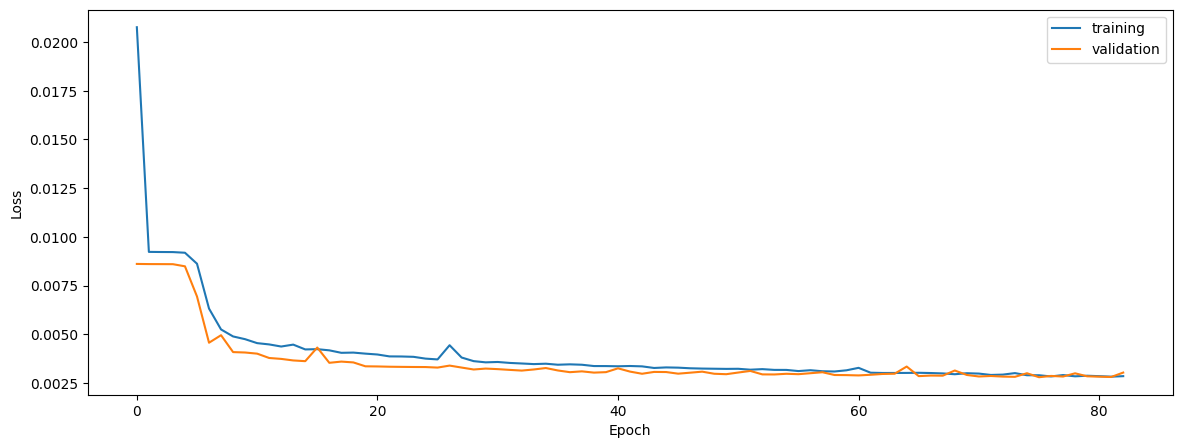

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8337002204337337
0.8237032197573799
0.8049923986028863


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8337002204337337
0.8237032197573799
0.8049923986028863


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.833052949762197
0.8232175551288523
0.8033195560577945


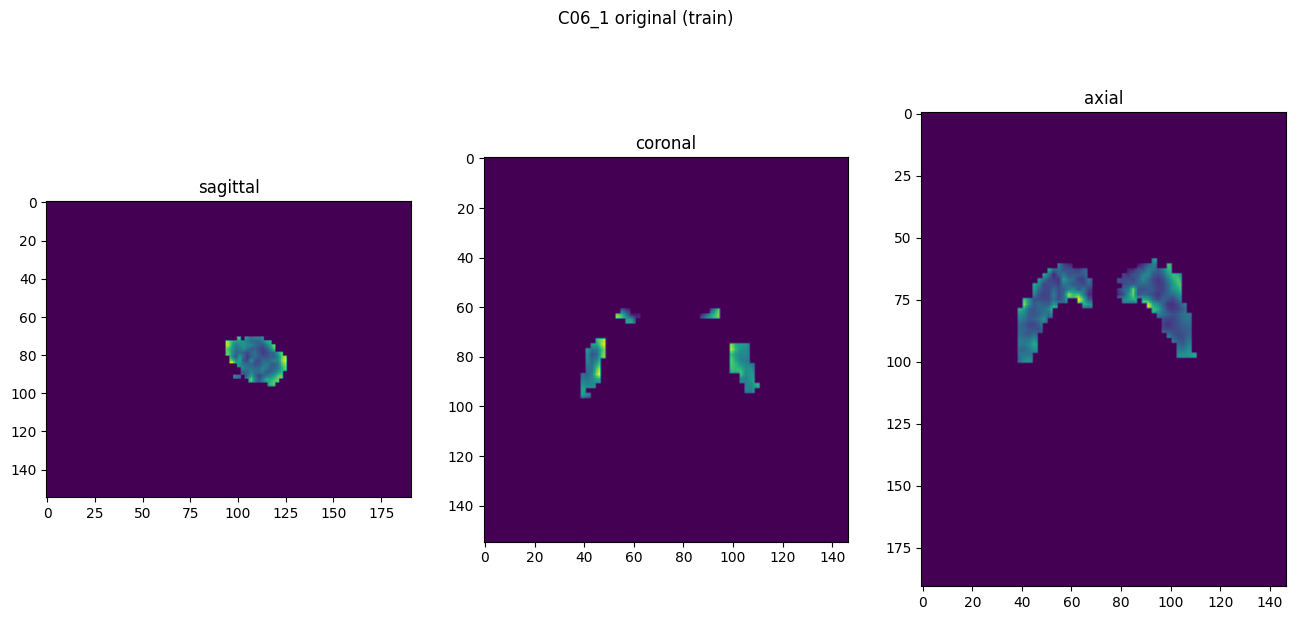

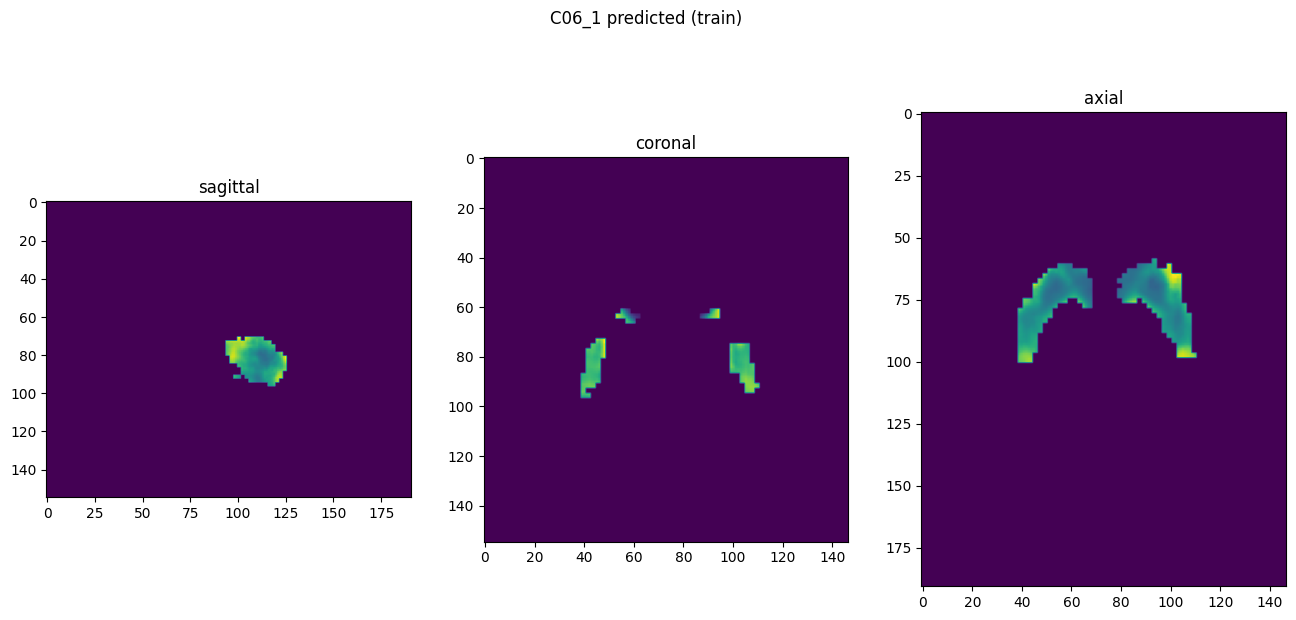

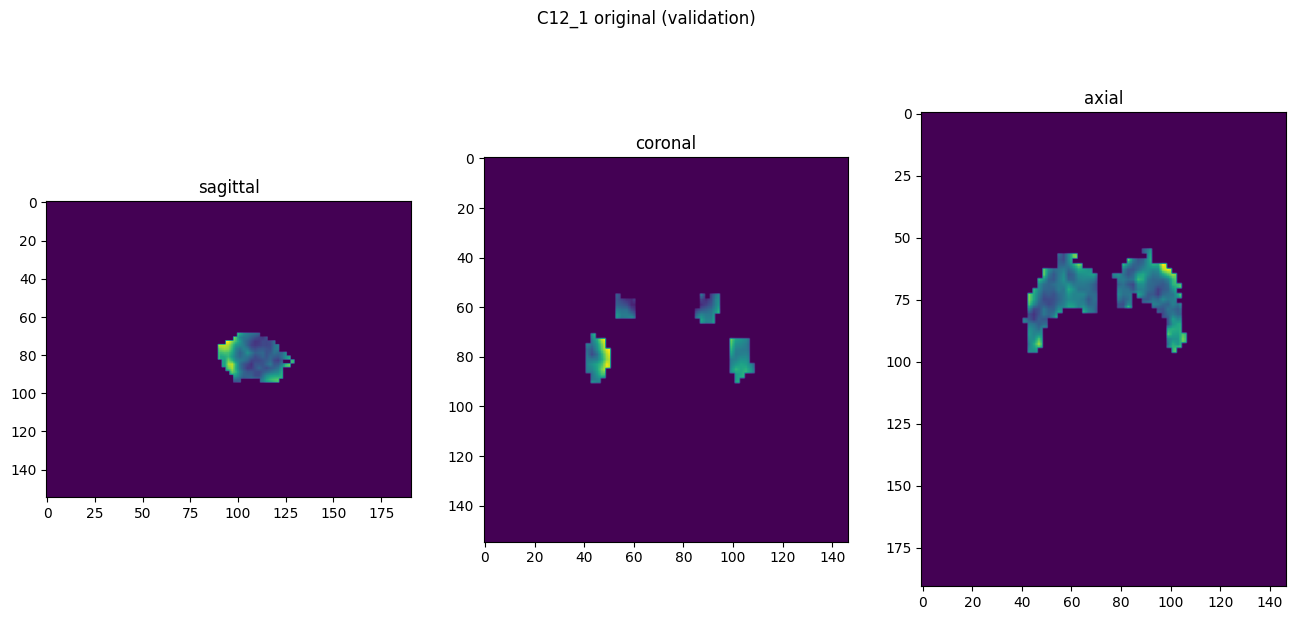

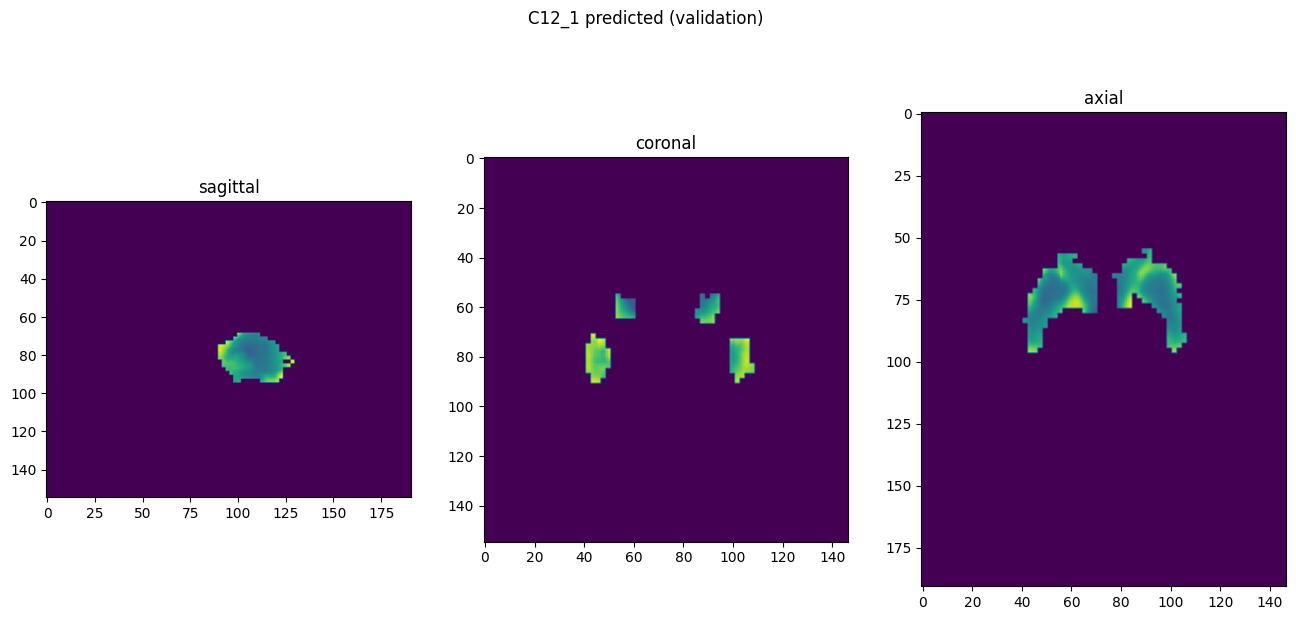

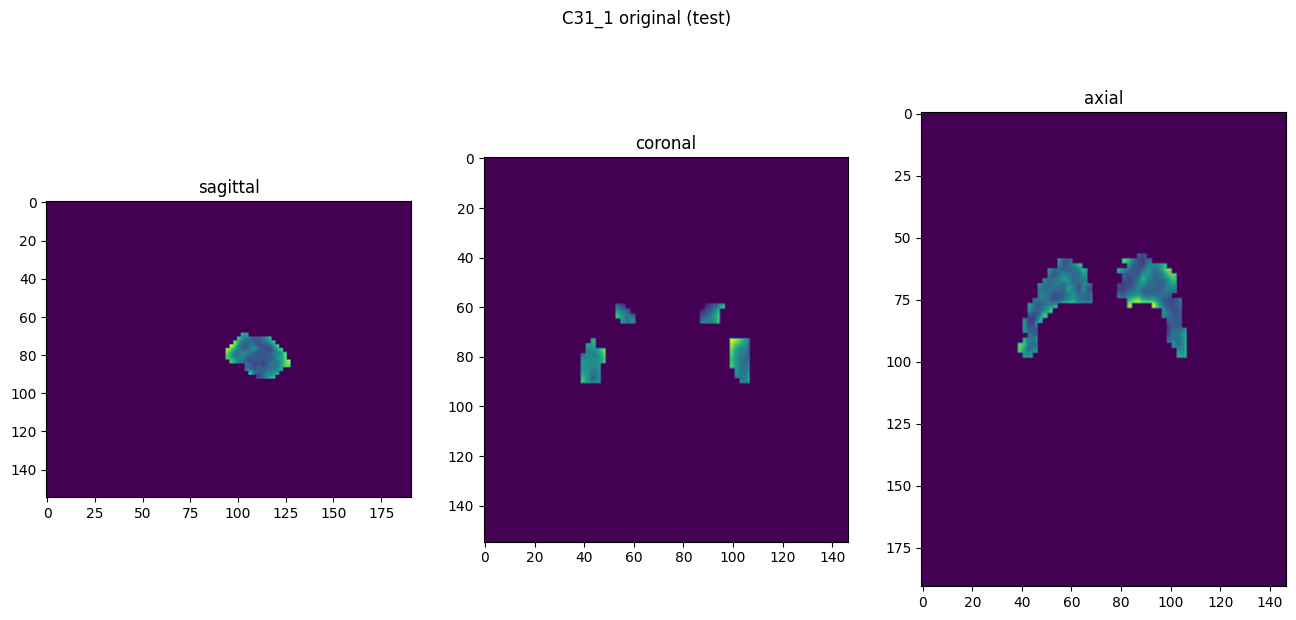

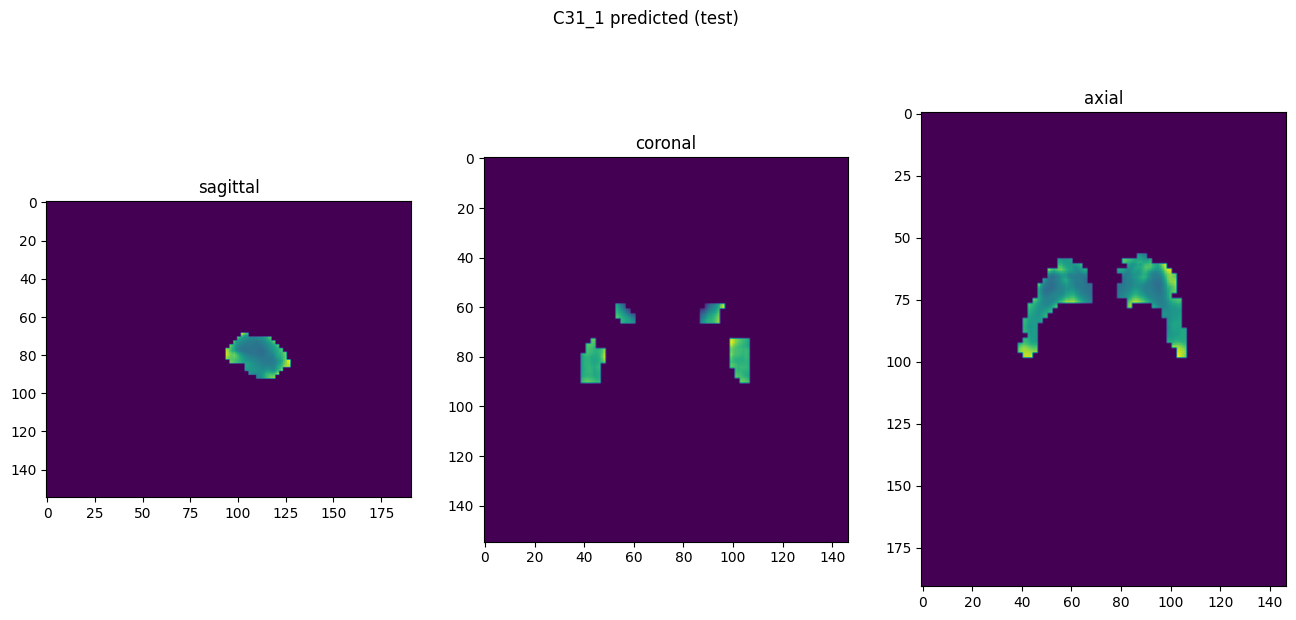

In [10]:
showResults(model, gen, threshold=None, background=False)